In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


2026-02-15 17:38:26.922622: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771177107.128534      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771177107.187897      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771177107.681356      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771177107.681397      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771177107.681400      17 computation_placer.cc:177] computation placer alr

In [3]:
df=pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df=df.drop(["customerID"],axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [7]:
df.isnull().sum()


gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [9]:
df=df.dropna()

In [10]:
df['Churn'].value_counts()


Churn
No     5163
Yes    1869
Name: count, dtype: int64

In [11]:
y=df["Churn"].map({"Yes":1,"No":0})
x=df.drop(["Churn"],axis=1)

In [12]:
categorical_cols=x.select_dtypes(include=['object']).columns
numerical_cols=x.select_dtypes(exclude=['object']).columns

categorical_cols,numerical_cols

(Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
        'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
        'PaperlessBilling', 'PaymentMethod'],
       dtype='object'),
 Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object'))

In [13]:
x=pd.get_dummies(x,categorical_cols,drop_first=True)

In [14]:
x_train,x_test,y_train,y_test =train_test_split(x,y,random_state=42,train_size=0.79)


In [15]:
scaler=StandardScaler()

x_train_scaled=scaler.fit_transform(x_train)
x_test_scaled=scaler.transform(x_test)

In [16]:
lr=LogisticRegression()
model_linear=lr.fit(x_train_scaled,y_train)
prediction=model_linear.predict(x_test_scaled)

In [17]:
print('Logistic Regression Score:',accuracy_score(y_test,prediction))
print('/nClassification Report:/n',classification_report(y_test,prediction))

Logistic Regression Score: 0.7901150981719702
/nClassification Report:/n               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1082
           1       0.63      0.52      0.57       395

    accuracy                           0.79      1477
   macro avg       0.73      0.70      0.72      1477
weighted avg       0.78      0.79      0.78      1477



In [18]:
from sklearn.ensemble import RandomForestClassifier
rf_model=RandomForestClassifier(n_estimators=300,random_state=42,class_weight='balanced')
rf_model.fit(x_train,y_train)
pred_rf=rf_model.predict(x_test)

In [19]:
print('Random Forest Classifier Score:',accuracy_score(y_test,pred_rf))
print('/nClassification Report:/n',classification_report(y_test,pred_rf))

Random Forest Classifier Score: 0.7928232904536222
/nClassification Report:/n               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1082
           1       0.65      0.48      0.55       395

    accuracy                           0.79      1477
   macro avg       0.74      0.69      0.71      1477
weighted avg       0.78      0.79      0.78      1477



In [20]:
results = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [accuracy_score(y_test, prediction),accuracy_score(y_test, pred_rf)]})

results

,Model,Accuracy
0,Logistic Regression,0.790115
1,Random Forest,0.792823


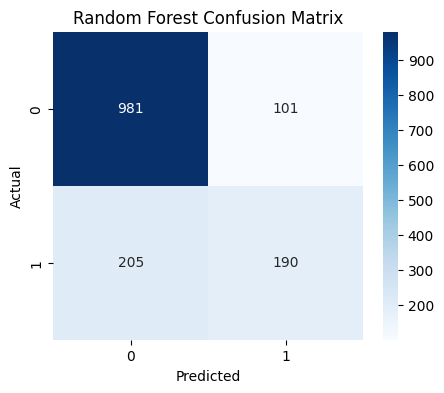

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

In [22]:
models=Sequential()
models.add(Dense(32,activation="relu",input_dim=len(x.columns),kernel_regularizer=l2(0.01)))
models.add(Dense(32,activation="relu",kernel_regularizer=l2(0.01)))
models.add(Dropout(0.2))
models.add(Dense(32,activation="relu",kernel_regularizer=l2(0.01)))
models.add(Dropout(0.2))
models.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-02-15 17:38:44.641429: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [23]:
early_stop = EarlyStopping(monitor='val_loss',mode='min',patience=10,verbose=1)

models.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [24]:
models.fit(x_train, y_train, epochs=50, batch_size=10)

Epoch 1/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6615 - loss: 25.1234
Epoch 2/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7361 - loss: 0.9400
Epoch 3/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7735 - loss: 0.8023
Epoch 4/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7728 - loss: 0.7707
Epoch 5/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7615 - loss: 0.7887
Epoch 6/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7640 - loss: 0.7580
Epoch 7/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7744 - loss: 0.7303
Epoch 8/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7768 - loss: 0.7102
Epoch 9/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7730 - loss: 0.7013
Epoch 10/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7781 - loss: 0.6797
Epoch 11/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7696 - loss: 0.6749
Epoch 12/50
556/556 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/ste